In [2]:
import os, sys, subprocess, shlex
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from REDInet import Utils
from functools import reduce

def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585", "outTable_530905096"],
                   ["outTable_572868058", "outTable_364841872", "outTable_814257267"],
                   ["outTable_110067244", "outTable_597789462", "outTable_208420383"]]

        rmsk_file = "rmsk_hg38.sorted.gtf.gz"

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]
        rmsk_file = "rmsk.sorted.gtf.gz"

    elif cell_line == "a549":
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
        rmsk_file = "rmsk.sorted.gtf.gz"
    else:
        samples= [["outTable_853538513", "outTable_921089530"]]
        rmsk_file = "rmsk.sorted.gtf.gz"

    utilities_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities"   
    files_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
    
    return samples, rmsk_file, utilities_path, files_path

def make_predictions(tables, tables_filespath, model_filepath, cell_line):
    
    model = tf.keras.models.load_model(model_filepath)
    with tqdm(total=int(len(tables)*len(tables[0]))) as pbar:
        if cell_line == "U87":
            n = 1
        else:
            n = 3
        for i in range(n):
            for j in range(len(tables[i])):

                intervals = pd.read_table(f"{tables_filespath}/{tables[i][j]}_intervals.tsv", sep="\t")
                X = pd.read_table(f"{tables_filespath}/{tables[i][j]}_feature_vectors.tsv", header=None, sep="\t")
                X_3d = Utils().from_2_to_3_dimensions(X, 8)
                X_3d_log2 = Utils().log_preprocessing(X_3d)
              
                output_table_prefix_filepath = "{}/{}_predictions.tsv".format(tables_filespath, tables[i][j])
                y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)

                intervals["SNP_Probability"] = 1.0 - y_hat_proba
                intervals["Editing_Probability"] = y_hat_proba

                intervals.to_csv(output_table_prefix_filepath, sep="\t", index=None)
                pbar.update(1)
                
def bona_fide_metrics_calculator(tables, tables_filespath, cells):
    if cells == "HEK293T":
        prefix = "HEK293T"
        suffix_1 = "WT-KO"
        suffix_2 = "OVE-KO"
    elif cells == "a549":
        prefix = "A549"
        suffix_1 = ""
    elif cells == "HEK":
        prefix = "HEK293T (Public Data)"
        suffix_1 = ""
    else:
        prefix = "U87"
        suffix_1 = ""
              
    y_true = []
    y_pred = []
    for i in range(len(tables)):
              
        sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                              sep="\t", usecols=["Region", "Position", "Class"])
        
        cols =  ["Region", "Position", "Strand", "Editing_Probability"]
        wt = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][0]}_predictions.tsv"), sep="\t", usecols=cols)
        adars_inactive = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)
        
        wt = wt.merge(sites, how="inner", on=["Region", "Position"])
        wt.loc[:, ["Region", "Position", "Class"]].to_csv(os.path.join(tables_filespath, 
                                                                       f"{tables[i][0]}_bona_fide_sites.tsv"), 
                                                          sep="\t", index=None)

        neg = sites[sites.loc[:, "Class"] == 0]
        adars_inactive = adars_inactive.merge(sites, how="inner", on=["Region", "Position"])
        if cells == "HEK293T":
            adars_inactive.loc[:, ["Region", "Position", "Class"]].to_csv(os.path.join(tables_filespath, 
                                                                                       f"{tables[i][1]}_bona_fide_sites_wt_ko.tsv"), 
                                                                          sep="\t", index=None)
        else:
            adars_inactive.loc[:, ["Region", "Position", "Class"]].to_csv(os.path.join(tables_filespath, 
                                                                                       f"{tables[i][1]}_bona_fide_sites.tsv"), 
                                                                          sep="\t", index=None)
            
        final = pd.concat([wt, adars_inactive], axis=0)

        y_true += final.loc[:, "Class"].tolist()
        y_pred += final.loc[:, "Editing_Probability"].tolist()

        
    Utils().make_confusion_matrix(y_true,  y_pred,
                                  title = f"{prefix} {suffix_1} Inference Confusion Matrix",
                                  figsize=(6,5),
                                  path=os.path.join(tables_filespath, f"{cells}_{suffix_1}_Inference_Conf_Matrix.tiff"))
              
    if cells == "HEK293T":
              
        y_true = []
        y_pred = []
        for i in range(len(tables)):
           
            sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][2]}_{tables[i][1]}_bona_fide_sites.tsv"),
                                  sep="\t", usecols=["Region", "Position", "Class"])
            
            cols =  ["Region", "Position", "Strand", "Editing_Probability"]
            adars_overexpressed = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][2]}_predictions.tsv"), sep="\t", usecols=cols)
            adars_inactive = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)

            adars_overexpressed = adars_overexpressed.merge(sites, how="inner", on=["Region", "Position"])
            adars_overexpressed.loc[:, ["Region", "Position", "Class"]].to_csv(os.path.join(tables_filespath, 
                                                                                            f"{tables[i][2]}_bona_fide_sites.tsv"), 
                                                                               sep="\t", index=None)
            
            neg = sites[sites.loc[:, "Class"] == 0]
            adars_inactive = adars_inactive.merge(sites, how="inner", on=["Region", "Position"])
            adars_inactive.loc[:, ["Region", "Position", "Class"]].to_csv(os.path.join(tables_filespath, 
                                                                                   f"{tables[i][1]}_bona_fide_sites_oe_ko.tsv"), 
                                                                      sep="\t", index=None)

            final = pd.concat([adars_overexpressed, adars_inactive], axis=0)
            

            y_true += final.loc[:, "Class"].tolist()
            y_pred += final.loc[:, "Editing_Probability"].tolist()
                        
        Utils().make_confusion_matrix(y_true,  y_pred,
                              title = f"{prefix} {suffix_2}",
                              figsize=(6,5),
                              path=os.path.join(tables_filespath, f"{cells}_{suffix_2}_Inference_Conf_Matrix.tiff"))
    
model_filepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

2024-08-12 11:19:46.999412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 11:19:46.999491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 11:19:46.999529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 11:19:47.010748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


100%|██████████| 6/6 [00:52<00:00,  8.80s/it]


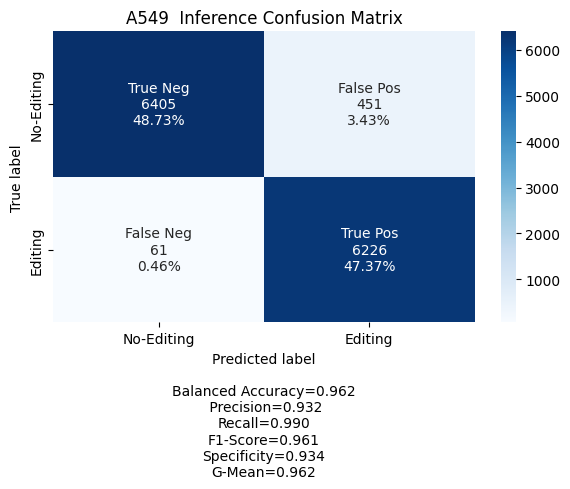

In [20]:
cells = "a549"

tables, rmsk, u_path, filespath =  give_inputs(cells) 
make_predictions(tables, filespath, model_filepath, cells)
bona_fide_metrics_calculator(tables, filespath, cells)

100%|██████████| 6/6 [00:39<00:00,  6.65s/it]


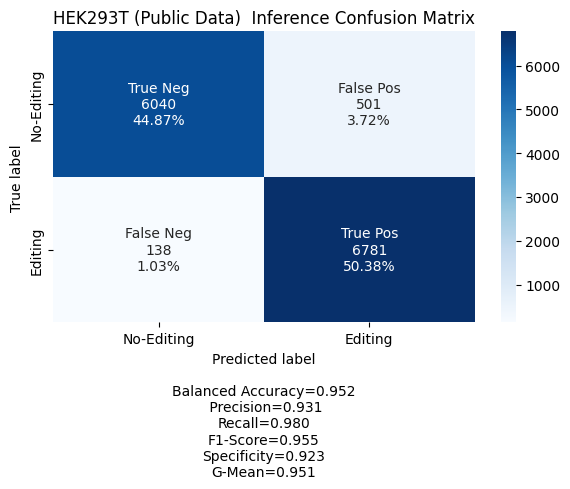

In [21]:
cells = "HEK"

tables, rmsk, u_path, filespath =  give_inputs(cells) 
make_predictions(tables, filespath, model_filepath, cells)
bona_fide_metrics_calculator(tables, filespath, cells)

100%|██████████| 9/9 [04:27<00:00, 29.72s/it]


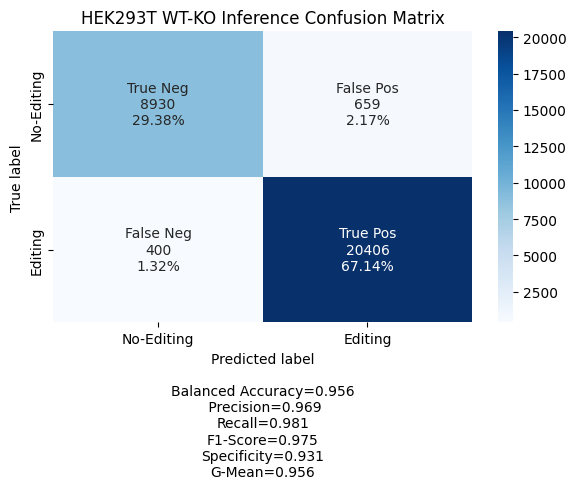

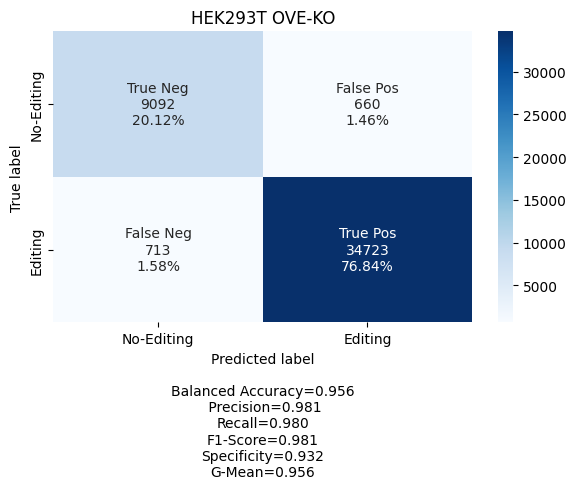

In [4]:
cells = "HEK293T"

tables, rmsk, u_path, filespath =  give_inputs(cells)
make_predictions(tables, filespath, model_filepath, cells)
bona_fide_metrics_calculator(tables, filespath, cells)

100%|██████████| 2/2 [00:17<00:00,  8.89s/it]


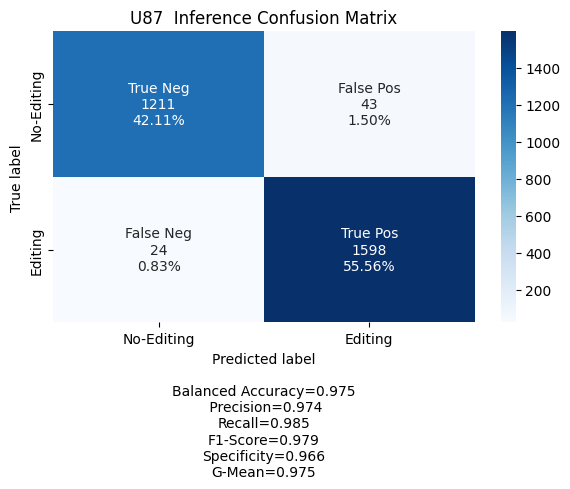

In [23]:
cells = "U87"

tables, rmsk, u_path, filespath =  give_inputs(cells)
make_predictions(tables, filespath, model_filepath, cells)
bona_fide_metrics_calculator(tables, filespath, cells)

In [5]:
import os, sys, subprocess, shlex, time, gzip, pysam
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import reduce
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder
from REDInet import Utils


def return_predicted_class(x):
    if x > 0.5:
        predicted_class = 1
    else:
        predicted_class = 0
    return predicted_class

def extraction_alu_check(prefix, cov_threshold, interval, positionslist):    
    
    starttime = datetime.now()

    editing = []
                                         
    with gzip.open(prefix+".gz") as redi:
        for c,l in enumerate(redi):
            line = l.decode("utf-8").rstrip().split("\t")
            if line[0].find("chr") != -1:
                if line[0] != "chrM":
                    if int(line[3]) != 2:
                        if line[2] == "A":
                            if line[4] != "-":
                                if int(line[4]) >= cov_threshold:
                                    editing.append(line)

            if c % 50000000 == 0:
                print(f"\tSites evaluated: {c}")
    print("Total evaluated rows:", c)
    editing = pd.DataFrame(editing)
    stoptime = datetime.now()
    print(f"[{datetime.now()}] Extraction of Editing Candidates finished for current sample. Elapsed time: {stoptime-starttime}.")
    columns = ["Region", "Position", "Ref", "Strand", "Cov", "Qual", "Bases", "AllSubs", "Freq", "gCov", "gQual", "g[A,C,G,T]", "gAllSubs", "gFreq"]
    editing.columns = columns
    print(f"[{datetime.now()}] Starting extraction of intervals.")
    ohe = OneHotEncoder()
    ohe.fit(np.array(["A", "C", "G", "T"]).reshape(-1, 1))

    intervals = []
    starttime_preds = datetime.now()
    total_extracted = 0
    features_extracted_filepath = prefix+ "_feature_vectors_alu_check.tsv"
    features_extracted = open(features_extracted_filepath, "w")

    editing.loc[:, "Position"] = editing.loc[:, "Position"].astype("int64")
    df = editing.merge(positionslist, how="inner", on=["Region", "Position"])
    print(f"[{datetime.now()}] Loading reditable with tabix and pysam:", prefix)
    start_time = datetime.now()
    srr = pysam.TabixFile(prefix+".gz")
    with tqdm(total=df.shape[0], position=0, leave=True) as pbar:
        for site in df.itertuples():
            start = int(site.Position) - ((interval-1)/2)
            stop = int(site.Position) + ((interval-1)/2)
            AGrna = eval(site.Bases)[2]/sum(eval(site.Bases))
            srr_interval = []
            for s in srr.fetch(site.Region, start-1, stop):
                srr_interval.append(s.split("\t"))
            srr_interval = pd.DataFrame(srr_interval, columns=columns)
            if srr_interval.shape[0] == interval and len(set(srr_interval["Strand"])) == 1:
                intervals.append([site.Region, site.Position, site.Ref, site.Strand, AGrna, site.Bases, start, stop, stop-start + 1, srr_interval.shape[0]])
                total_extracted += 1
                strand = site.Strand
                seq = srr_interval.Ref.values.reshape(-1,1)
                seq_ohe = ohe.transform(seq).toarray().T
                vects_freqs = []
                strands = []
                vects = []
                for vect in srr_interval["Bases"]:
                    vect = np.array(eval(vect))
                    cov = sum(vect)
                    vect_freqs = vect / cov
                    vects_freqs.append(vect_freqs)
                    vects.append(vect)
                vects_freqs = np.array(vects_freqs).T
                vects = np.array(vects).T
                encoded_site = pd.concat([pd.DataFrame(seq_ohe), pd.DataFrame(vects_freqs)])
                encoded_site.reset_index(drop=True, inplace=True)
                if strand == 0: 
                    encoded_site = pd.DataFrame(np.flip(encoded_site.values, axis=1))
                encoded_site.to_csv(features_extracted, mode="a", sep="\t", header = None, index=None)
            pbar.update(1)
    intervals = pd.DataFrame(intervals)
    stop_time_global = datetime.now()
    print(f"[{datetime.now()}] Features Extraction Finished. Elapsed time {datetime.now()-starttime_preds}.")
    features_extracted.close()
    
    intervals.columns = ["Region", "Position", "RefBase", "Strand", "FreqAGrna", "BasesCounts", "Start", "Stop", "Intlen", "TabixLen"]
    intervals.to_csv(prefix + "_intervals_alu_check.tsv", sep="\t", index=None)
    print(f"[{datetime.now()}] Computation Finished. Total Elapsed time: {datetime.now()-starttime}")

def make_predictions_alu_check(tables, tables_filespath, model_filepath):
    
    model = tf.keras.models.load_model(model_filepath)
    with tqdm(total=int(len(tables)*len(tables[0]))) as pbar:
        for i in range(3):
            for j in range(2):
                intervals = pd.read_table(f"{tables_filespath}/{tables[i][j]}_intervals_alu_check.tsv", sep="\t")
                X = pd.read_table(f"{tables_filespath}/{tables[i][j]}_feature_vectors_alu_check.tsv", header=None, sep="\t")
                X_3d = Utils().from_2_to_3_dimensions(X, 8)
                X_3d_log2 = Utils().log_preprocessing(X_3d)
              
                output_table_prefix_filepath = "{}/{}_predictions_alu_check.tsv".format(tables_filespath, tables[i][j])
                y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)
    
                intervals["SNP_Probability"] = 1.0 - y_hat_proba
                intervals["Editing_Probability"] = y_hat_proba
    
                intervals.to_csv(output_table_prefix_filepath, sep="\t", index=None)
                pbar.update(1)

cell_line = "HEK293T"

filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
model_filepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

samples = [["outTable_599710609", "outTable_905657585", "outTable_530905096"],
           ["outTable_572868058", "outTable_364841872", "outTable_814257267"],
           ["outTable_110067244", "outTable_597789462", "outTable_208420383"]]


data = []
for i in range(3):
    df = pd.read_table(f"{filespath}/{samples[i][2]}_{samples[i][1]}_bona_fide_sites.tsv")
    df = df[df.loc[:, "RMSK-Reg"].str.find("Alu")!=-1]
    df.loc[:, "Position"] = df.loc[:, "Position"].astype("int64")
    data.append(df.loc[:, ["Region", "Position"]])

oepositions = reduce(lambda  first,second: pd.merge(first,second, on=["Region", "Position"],how='inner'), data)

data = []
for i in range(3):
    df = pd.read_table(f"{filespath}/{samples[i][2]}_predictions.tsv", usecols=["Region", "Position"])
    df.loc[:, "Position"] = df.loc[:, "Position"].astype("int64")
    data.append(df)

oecommon = reduce(lambda  first,second: pd.merge(first,second, on=["Region", "Position"], how='inner'), data)
oecommon = oecommon.merge(oepositions, how="inner", on=["Region", "Position"])


inputs = []
for i in range(len(samples)):
    inputs.append([os.path.join(filespath, f"{samples[i][0]}"), 50, 101, oecommon])
    inputs.append([os.path.join(filespath, f"{samples[i][1]}"), 50, 101, oecommon])

with Pool(6) as pool:
    pool.starmap(extraction_alu_check, inputs)

make_predictions_alu_check(samples, filespath, model_filepath)


	Sites evaluated: 0	Sites evaluated: 0	Sites evaluated: 0	Sites evaluated: 0	Sites evaluated: 0	Sites evaluated: 0





	Sites evaluated: 50000000
	Sites evaluated: 50000000
	Sites evaluated: 50000000
	Sites evaluated: 50000000
	Sites evaluated: 50000000
	Sites evaluated: 50000000
	Sites evaluated: 100000000
	Sites evaluated: 100000000
	Sites evaluated: 100000000
	Sites evaluated: 100000000
	Sites evaluated: 100000000
	Sites evaluated: 100000000
	Sites evaluated: 150000000
	Sites evaluated: 150000000
	Sites evaluated: 150000000
	Sites evaluated: 150000000
	Sites evaluated: 150000000
	Sites evaluated: 150000000
	Sites evaluated: 200000000
	Sites evaluated: 200000000
Total evaluated rows: 194677901
	Sites evaluated: 200000000
	Sites evaluated: 200000000
Total evaluated rows: 199831579
[2024-08-12 14:45:18.476834] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:05:19.642807.
[2024-08-12 14:45:18.479429] Starting extraction of intervals.
[2024-08-12 14:45:22.9

  7%|▋         | 349/4988 [00:04<00:55, 83.76it/s] 

Total evaluated rows: 205675117


  8%|▊         | 411/4988 [00:04<00:43, 106.02it/s]

[2024-08-12 14:45:34.075826] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:05:35.236787.
[2024-08-12 14:45:34.078239] Starting extraction of intervals.
[2024-08-12 14:45:34.170870] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_110067244


 12%|█▏        | 523/4499 [00:05<00:37, 104.64it/s]]

[2024-08-12 14:45:39.869500] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:05:41.031579.
[2024-08-12 14:45:39.872390] Starting extraction of intervals.


 21%|██        | 938/4499 [00:10<00:58, 60.63it/s]] 

[2024-08-12 14:45:44.993869] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_597789462


 25%|██▍       | 1246/4988 [00:08<00:23, 161.93it/s]

[2024-08-12 14:45:53.494454] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_364841872


 68%|██████▊   | 3387/4988 [00:22<00:10, 153.67it/s]

[2024-08-12 14:46:07.155504] Features Extraction Finished. Elapsed time 0:00:48.673492.


 86%|████████▌ | 3854/4499 [00:32<00:03, 194.96it/s]

[2024-08-12 14:46:07.190129] Computation Finished. Total Elapsed time: 0:06:08.356143


100%|██████████| 4499/4499 [00:37<00:00, 119.14it/s]


[2024-08-12 14:46:12.025433] Features Extraction Finished. Elapsed time 0:00:49.045369.
[2024-08-12 14:46:12.053681] Computation Finished. Total Elapsed time: 0:06:13.216042


100%|██████████| 4988/4988 [00:31<00:00, 156.00it/s]


[2024-08-12 14:46:17.106298] Features Extraction Finished. Elapsed time 0:00:43.025847.
[2024-08-12 14:46:17.140460] Computation Finished. Total Elapsed time: 0:06:18.301454


 79%|███████▉  | 3950/4988 [00:34<00:16, 61.18it/s] 

	Sites evaluated: 250000000


100%|██████████| 4988/4988 [00:43<00:00, 115.51it/s]


[2024-08-12 14:46:36.798328] Features Extraction Finished. Elapsed time 0:00:56.923583.
[2024-08-12 14:46:36.827238] Computation Finished. Total Elapsed time: 0:06:37.989357
	Sites evaluated: 250000000
Total evaluated rows: 288775068
[2024-08-12 14:47:44.060283] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:07:45.225450.
[2024-08-12 14:47:44.063689] Starting extraction of intervals.
	Sites evaluated: 300000000
[2024-08-12 14:47:59.611197] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_572868058


100%|██████████| 4954/4954 [00:36<00:00, 136.20it/s]


[2024-08-12 14:48:36.123185] Features Extraction Finished. Elapsed time 0:00:52.055794.
[2024-08-12 14:48:36.155129] Computation Finished. Total Elapsed time: 0:08:37.320353
	Sites evaluated: 350000000
Total evaluated rows: 369524874
[2024-08-12 14:49:45.101966] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:09:46.269384.
[2024-08-12 14:49:45.105627] Starting extraction of intervals.
[2024-08-12 14:50:01.597064] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_599710609


100%|██████████| 4986/4986 [00:45<00:00, 109.34it/s]


[2024-08-12 14:50:47.302850] Features Extraction Finished. Elapsed time 0:01:02.194320.
[2024-08-12 14:50:47.335227] Computation Finished. Total Elapsed time: 0:10:48.502682


 67%|██████▋   | 6/9 [00:46<00:23,  7.68s/it]


In [6]:
def return_A(bases_counts):
    return eval(bases_counts)[0]

def return_G(bases_counts):
    return eval(bases_counts)[2]


cols = ["Region", "Position", "BasesCounts", "Editing_Probability"]

comparative_table = []

for i in range(3):
    for j in range(3):
        if j <= 1:
            df = pd.read_table(f"{filespath}/{samples[i][j]}_predictions_alu_check.tsv", usecols=cols)
        else:
            df = pd.read_table(f"{filespath}/{samples[i][j]}_predictions.tsv", usecols=cols)
        df.loc[:, "Predicted_Class"] =  df.loc[:, "Editing_Probability"].apply(return_predicted_class)
        df.drop("Editing_Probability", axis=1, inplace=True)
        df.columns = ["Region", "Position", f"{samples[i][j]} BasesCounts", f"{samples[i][j]} Predicted Class"]
        comparative_table.append(df)
        
comparative_table = reduce(lambda  first,second: pd.merge(first,second, on=["Region", "Position"],how='inner'), comparative_table)
comparative_table.to_csv(os.path.join(filespath, 
                                      "Common_Positives_On_Alu_Genomic_Positions_Comparative_table.tsv"), 
                         sep="\t", index=None)

print(f"Total Number of Common Alu Sites: {comparative_table.shape[0]}")

stats = []

for i in range(3):
    for j in range(len(samples[i])):
        
        if j == 0:
            genotype = "ADAR1 Wild-Type"
        elif j ==1:
            genotype = "ADAR1 Knock-Out"
        else:
            genotype = "ADAR1 Overexpressed"
        
        number_of_positives = comparative_table.loc[:,  f"{samples[i][j]} Predicted Class"].value_counts(normalize=True)[1]
        number_of_positives = number_of_positives*100
        a_to_g = comparative_table[comparative_table.loc[:,  f"{samples[i][j]} Predicted Class"] == 1]
        a_to_g.loc[:, f"{samples[i][j]} Raw_A"] = a_to_g.loc[:, f"{samples[i][j]} BasesCounts"].apply(return_A)
        tot_A = sum(a_to_g.loc[:,  f"{samples[i][j]} Raw_A"].tolist())
        a_to_g.loc[:, f"{samples[i][j]} Raw_G"] = a_to_g.loc[:, f"{samples[i][j]} BasesCounts"].apply(return_G)
        tot_G = sum(a_to_g.loc[:,  f"{samples[i][j]} Raw_G"].tolist())
        alu_index = 100*(tot_G/(tot_A+tot_G))
        
        stats.append([genotype, i+1, number_of_positives, alu_index])
        
stats = pd.DataFrame(stats, columns=["Genotype", "Sample Number", 
                                     "N° Predicted Positives in pct.", 
                                     "Alu Index (Value x 100)"])

stats = stats.iloc[[1, 4, 6, 0, 3, 5, 2, 5, 7], :]
stats.to_csv(os.path.join(filespath, "HEK293T_Common_Alu_Barplots_Data.tsv"), sep="\t", index=None)

Total Number of Common Alu Sites: 4472


/tmp/ipykernel_41851/20264666.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_to_g.loc[:, f"{samples[i][j]} Raw_A"] = a_to_g.loc[:, f"{samples[i][j]} BasesCounts"].apply(return_A)
/tmp/ipykernel_41851/20264666.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_to_g.loc[:, f"{samples[i][j]} Raw_G"] = a_to_g.loc[:, f"{samples[i][j]} BasesCounts"].apply(return_G)
/tmp/ipykernel_41851/20264666.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

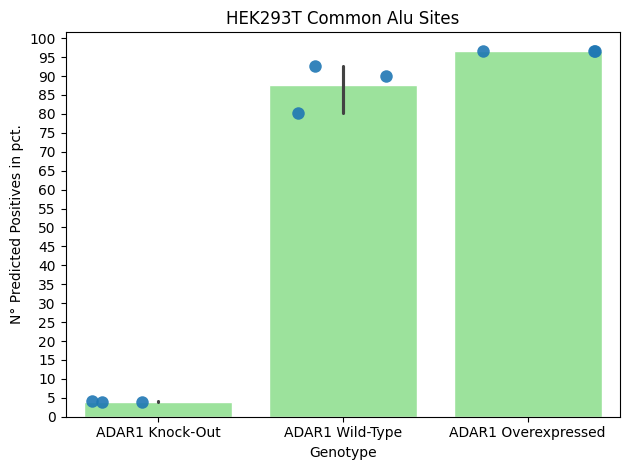

In [7]:
fig, ax = plt.subplots()
ax.set_yticks(np.arange(0,105, 5))

with sn.axes_style("whitegrid"):
    sn.barplot(data=stats, x="Genotype", y="N° Predicted Positives in pct.", 
               fill=True, color="lightgreen").set(title='HEK293T Common Alu Sites')

    sn.stripplot(data=stats, x="Genotype", y="N° Predicted Positives in pct.",
                 dodge=True, size=9, alpha=0.9, jitter=0.40)

    fig.tight_layout()

    plt.savefig(f"{filespath}/HEK293T_Number_Predicted_Positives_On_Common_Alu_Sites_Barplot.tiff", dpi=600, 
                bbox_inches='tight', facecolor='white', transparent=False) 
    plt.show()

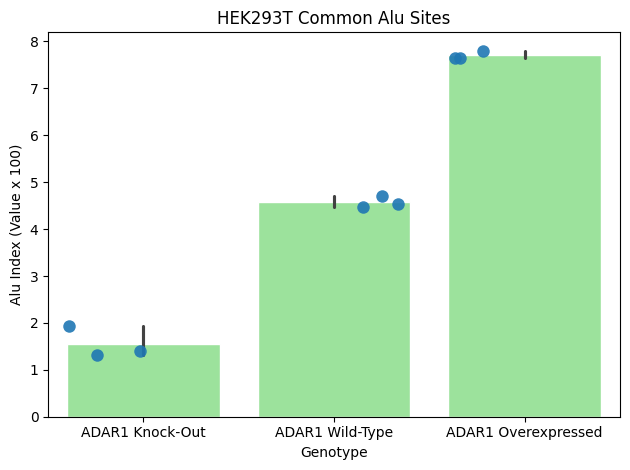

In [8]:
fig, ax = plt.subplots()

with sn.axes_style("whitegrid"):
    sn.barplot(data=stats, x="Genotype", y="Alu Index (Value x 100)", 
               fill=True, color="lightgreen").set(title='HEK293T Common Alu Sites')

    sn.stripplot(data=stats, x="Genotype", y="Alu Index (Value x 100)",
                 dodge=True, size=9, alpha=0.9, jitter=0.40)

    fig.tight_layout()

    plt.savefig(f"{filespath}/HEK293T_Alu_Index_On_Common_Alu_Sites_Barplot.tiff", dpi=600, 
                bbox_inches='tight', facecolor='white', transparent=False) 
    plt.show()